-----------
Initializing structure...
time for choose_chunkdivision = 0.000597954 s
Working in 2D dimensions.
Computational cell is 16 x 16 x 0 with resolution 50
     cylinder, center = (0,0,0)
          radius 1.6, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (3.4,3.4,3.4)
     cylinder, center = (0,0,0)
          radius 0.9, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
     cylinder, center = (0,0,0)
          radius 3.2, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (3.4,3.4,3.4)
     cylinder, center = (0,0,0)
          radius 2.4, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 1.12198 s
-----------


FloatProgress(value=0.0, description='0% done ', max=400.0)

Meep progress: 17.88/400.0 = 4.5% done in 4.0s, 85.5s to go
on time step 1793 (time=17.93), 0.00223118 s/step
Meep progress: 39.82/400.0 = 10.0% done in 8.0s, 72.4s to go
on time step 3988 (time=39.88), 0.00182246 s/step
Meep progress: 62.07/400.0 = 15.5% done in 12.0s, 65.3s to go
on time step 6214 (time=62.14), 0.0017977 s/step
Meep progress: 84.47/400.0 = 21.1% done in 16.0s, 59.8s to go
on time step 8455 (time=84.55), 0.001785 s/step
Meep progress: 106.76/400.0 = 26.7% done in 20.0s, 54.9s to go
on time step 10685 (time=106.85), 0.00179419 s/step
Meep progress: 129.15/400.0 = 32.3% done in 24.0s, 50.3s to go
on time step 12925 (time=129.25), 0.00178621 s/step
Meep progress: 151.41/400.0 = 37.9% done in 28.0s, 46.0s to go
on time step 15151 (time=151.51), 0.00179731 s/step
Meep progress: 173.66/400.0 = 43.4% done in 32.0s, 41.7s to go
on time step 17377 (time=173.77), 0.00179725 s/step
Meep progress: 195.64000000000001/400.0 = 48.9% done in 36.0s, 37.6s to go
on time step 19576 (tim

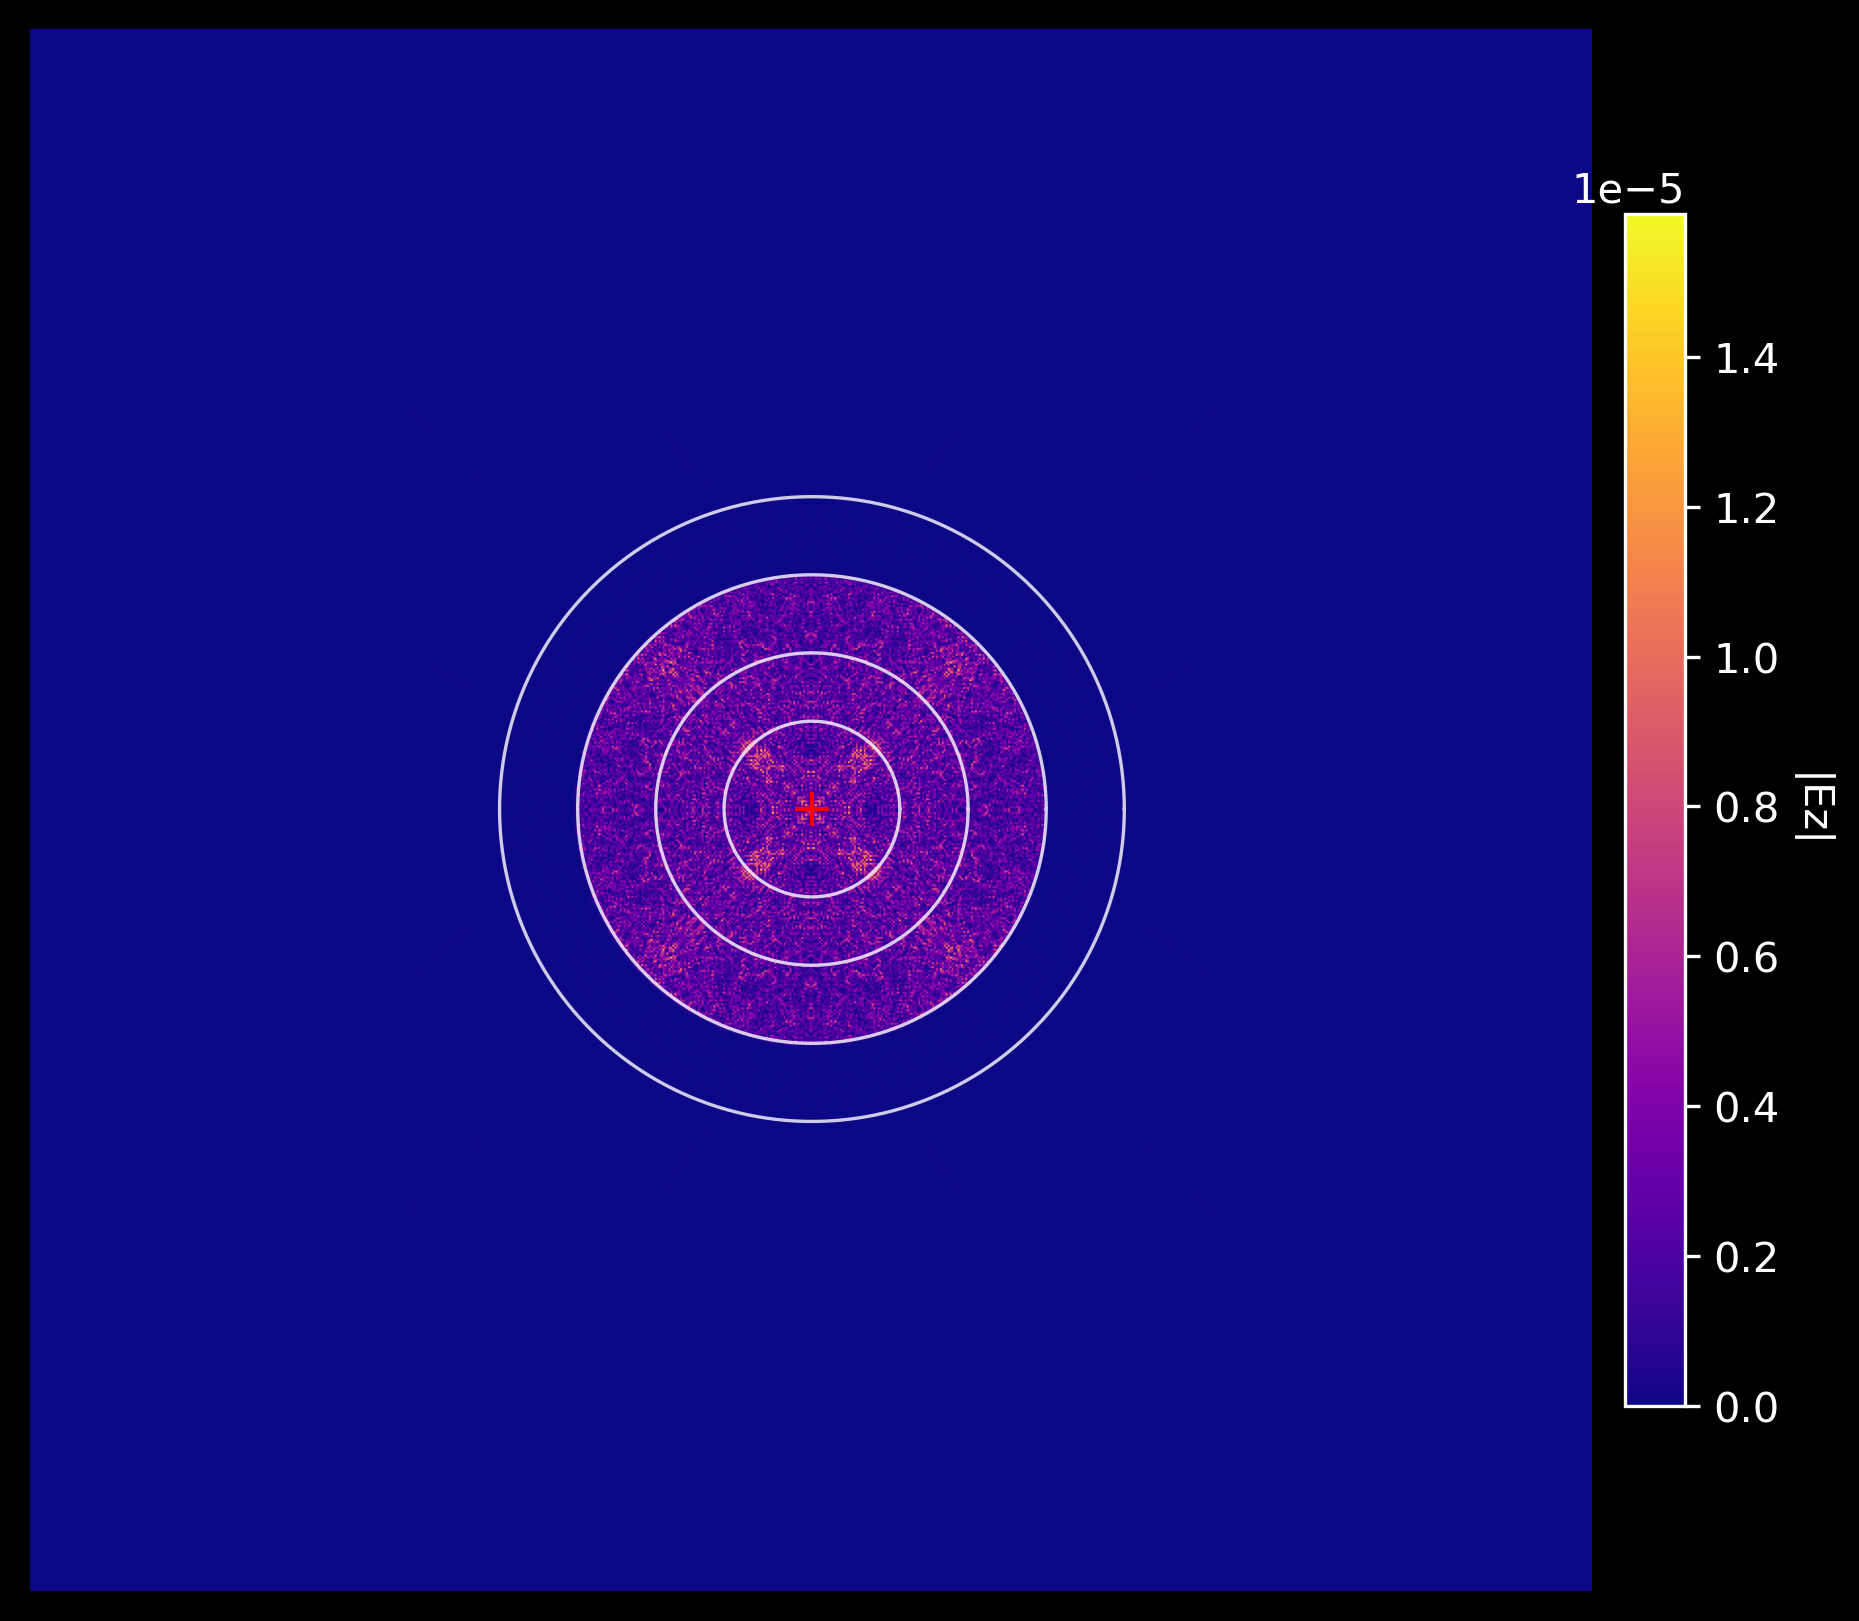

In [1]:
# 雙環干涉結構
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

# -----------------------------
# 參數（可依需求調整）
resolution = 50        # 建議 30~80；越高越漂亮但越慢
pml_thickness = 1.0
cell_size = mp.Vector3(16, 16, 0)

# 介電環參數（同心雙環）
# 內環：半徑 r1_in .. r1_out（空心）
r1_in = 0.9
r1_out = 1.6

# 外環：半徑 r2_in .. r2_out（空心）
r2_in = 2.4
r2_out = 3.2

eps_ring = 3.4  # 介電常數對應折射率 ≈ 1.84

# -----------------------------
# 構建幾何（空氣背景，使用圓柱 + 挖空產生環）
geometry = []

# 內環：先放一個實心介電圓盤，再挖掉內圓（用 air 圓柱覆蓋）
geometry.append(mp.Cylinder(radius=r1_out, height=mp.inf,
                            center=mp.Vector3(0, 0),
                            material=mp.Medium(index=math.sqrt(eps_ring))))
geometry.append(mp.Cylinder(radius=r1_in, height=mp.inf,
                            center=mp.Vector3(0, 0),
                            material=mp.air))  # 挖空

# 外環：同理
geometry.append(mp.Cylinder(radius=r2_out, height=mp.inf,
                            center=mp.Vector3(0, 0),
                            material=mp.Medium(index=math.sqrt(eps_ring))))
geometry.append(mp.Cylinder(radius=r2_in, height=mp.inf,
                            center=mp.Vector3(0, 0),
                            material=mp.air))  # 挖空

# -----------------------------
# PML 與來源（中心脈衝）
pml_layers = [mp.PML(pml_thickness)]

f0 = 0.25   # 中心頻率（可試調以捕捉共振）
df = 0.12   # 頻寬
sources = [mp.Source(mp.GaussianSource(f0, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, 0))]  # 中心點源

# -----------------------------
# 建立模擬
sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    dimensions=2)

# -----------------------------
# 存最後一幀（或多幀）
frames = []
def store_frame(sim):
    ez = sim.get_array(center=mp.Vector3(), size=cell_size, component=mp.Ez)
    frames.append(np.copy(ez))

# 存每 2 時間單位一幀，總模擬到 t = 400（可改）
t_end = 400
dt_store = 2
sim.run(mp.at_every(dt_store, store_frame), until=t_end)

# -----------------------------
# 視覺化（取最後一幀，顯示 |Ez|）
ez_final = frames[-1]
abs_ez = np.abs(ez_final)

plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(6,6), dpi=300)

# 固定色標以便比較：使用全域最大做 vmax
vmax = abs_ez.max()
im = ax.imshow(abs_ez, origin='lower', cmap='plasma', vmin=0, vmax=vmax)

# 疊上雙環輪廓（把物理座標映成像素座標）
ny, nx = abs_ez.shape  # rows (y), cols (x)
theta = np.linspace(0, 2*np.pi, 400)

def phys_to_pix(x, y):
    xpix = (x + cell_size.x/2) * (nx / cell_size.x)
    ypix = (y + cell_size.y/2) * (ny / cell_size.y)
    return xpix, ypix

# 畫內環外圓 r1_out 與內圓 r1_in
for r, color in [(r1_out, 'white'), (r1_in, 'white'), (r2_out, 'white'), (r2_in, 'white')]:
    rx = r * np.cos(theta)
    ry = r * np.sin(theta)
    xpix, ypix = phys_to_pix(rx, ry)
    ax.plot(xpix, ypix, color=color, lw=0.8, alpha=0.8)

# 標示中心點
cx, cy = phys_to_pix(0, 0)
ax.plot(cx, cy, 'r+', markersize=8)

ax.axis('off')
cbar = plt.colorbar(im, ax=ax, fraction=0.036, pad=0.02)
cbar.set_label('|Ez|', rotation=270, labelpad=12)

plt.tight_layout(pad=0)
out_fname = "dual_ring_interference.png"
plt.savefig(out_fname, dpi=600, bbox_inches='tight', pad_inches=0)
print(f"Saved image: {out_fname}")

plt.show()
